# Tarea 1: Uso de técnicas de PLN para preprocesamiento de textos

**Ricardo Calvo Perez - A01028889**

### 0. Importar librerias

In [ ]:
!pip install gensim
!pip install nrclex
!wget -nc https://raw.githubusercontent.com/aditeyabaral/lok-sabha-election-twitter-analysis/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt -P /content/

from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler
from nltk.corpus import sentiwordnet as swn
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import spacy
import nltk
import re
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from nrclex import NRCLex
from gensim.models import Word2Vec

  Using cached NRCLex-4.0-py3-none-any.whl.metadata (3.2 kB)
INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
  Using cached NRCLex-3.0.0-py3-none-any.whl
--2025-11-07 00:42:36--  https://raw.githubusercontent.com/aditeyabaral/lok-sabha-election-twitter-analysis/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2579145 (2.5M) [text/plain]
Saving to: ‘/content/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt’

NRC-Emotion-Lexicon 100%[===================>]   2.46M  --.-KB/s    in 0.06s   

2025-11-07 00:42:36 (44.2 MB/s) - ‘/content/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt’ saved [2579145/2579145]



## 1. Pipeline

**1.1 Codificación y Normalización de Texto**

El primer paso consiste en garantizar que todo el texto esté en UTF-8 y aplicar normalización Unicode (NFKC). Esto nos permite unificar variantes de caracteres como los pueden ser “á” y “á”. Además de qye se corrigen errores comunes de codificación conservando el uso de tildes y diacríticos, ya que aportan significado en español (“papa” ≠ “papá”).


In [ ]:
labels = []
raw_X = []

with open('/content/originallTraining.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            labels.append(parts[2])
            raw_X.append('\t'.join(parts[3:]))

for line in raw_X:
    print(line)

unique_labels = list(set(labels))
print("\nUnique labels:")
print(unique_labels)

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)
Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)
with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.
Talking about ACT's && SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.
They may have a SuperBowl in Dallas, but Dallas ain't winning a SuperBowl. Not with that quarterback and owner. @S4NYC @RasmussenPoll
Im bringing the monster load of candy tomorrow, I just hope it doesn't get all squiched
Apple software, retail chiefs out in overhaul: SAN FRANCISCO Apple Inc CEO Tim Cook on Monday replaced the heads... http://bit.ly/XQEhJU
#Livewire Nadal confirmed for Mexican Open in February: Rafael Nadal is set to play at the Me... http://bit.ly/WY4Vjy  #LiveWireAthletics
#Iran US delisting MKO from global terrorists 

**1.2 Manejo de Mayúsculas y Minúsculas**

Se transforma todo el texto a minúsculas, pero se mantiene una marca cuando una palabra aparece en MAYÚSCULAS completas, ya que esto puede representar énfasis o gritos en un tweet, como por ejemplo la frase: “ESTÁ GENIAL” → está genial [ALLCAPS=1].

In [ ]:

def process_caps(raw_X):
  processed_caps_X = []
  for line in raw_X:
      words = line.split()
      processed_line = []
      for word in words:
          if word.isupper():
              processed_line.append(word)
          else:
              processed_line.append(word.lower())
      processed_caps_X.append(" ".join(processed_line))
  return processed_caps_X

processed_caps_X = process_caps(raw_X)

for line in processed_caps_X:
    print(line)

gas by my house hit $3.39!!!! i'm going to chapel hill on sat. :)
iranian general says israel's iron dome can't deal with their missiles (keep talking like that and we may end up finding out)
with J davlar 11th. main rivals are team poland. hopefully we an make it a successful end to a tough week of training tomorrow.
talking about act's && sat's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.
they may have a superbowl in dallas, but dallas ain't winning a superbowl. not with that quarterback and owner. @S4NYC @rasmussenpoll
im bringing the monster load of candy tomorrow, I just hope it doesn't get all squiched
apple software, retail chiefs out in overhaul: SAN FRANCISCO apple inc CEO tim cook on monday replaced the heads... http://bit.ly/xqehju
#livewire nadal confirmed for mexican open in february: rafael nadal is set to play at the me... http://bit.ly/wy4vjy #livewireathletics
#iran US delisting MKO from global terrorists l

**1.3 Limpieza con Expresiones Regulares (Regex)**


Se emplean expresiones regulares para identificar y procesar elementos específicos dentro del texto. En primer lugar, ciertos elementos serán eliminados ya que en la mayoría de los casos no aportan valor semántico directo y pueden introducir ruido innecesario. Entre ellos se encuentran las `URLs`, las menciones `@usuario` y los números. Estos componentes suelen estar más relacionados con metadatos o con información contextual que no refleja el sentimiento de manera explícita.

Por otro lado, existen elementos que sí se conservarán y normalizarán, debido a que aportan información valiosa para el análisis de sentimientos. Entre ellos se incluyen los `hashtags`, que muchas veces concentran el tema y la emoción del tweet; las onomatopeyas y expresiones de risa como `jajaja`, `jeje` o `xd`, que denotan positividad o diversión, y los emoticonos formados con símbolos como `:D`, `:(` o `;)`, que se transformarán en etiquetas normalizadas para mantener su carga emocional explícita.

In [ ]:
def process_regex(processed_caps_X):
  processed_regex_X = []
  for line in processed_caps_X:
      # Remove URLs
      line = re.sub(r'http\S+', '', line)
      line = re.sub(r'www.+', '', line)
      # Remove mentions
      line = re.sub(r'@\S+', '', line)
      processed_regex_X.append(line)

  return processed_regex_X

processed_regex_X = process_regex(processed_caps_X)

for line in processed_regex_X:
    print(line)

gas by my house hit $3.39!!!! i'm going to chapel hill on sat. :)
iranian general says israel's iron dome can't deal with their missiles (keep talking like that and we may end up finding out)
with J davlar 11th. main rivals are team poland. hopefully we an make it a successful end to a tough week of training tomorrow.
talking about act's && sat's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.
they may have a superbowl in dallas, but dallas ain't winning a superbowl. not with that quarterback and owner.  
im bringing the monster load of candy tomorrow, I just hope it doesn't get all squiched
apple software, retail chiefs out in overhaul: SAN FRANCISCO apple inc CEO tim cook on monday replaced the heads... 
#livewire nadal confirmed for mexican open in february: rafael nadal is set to play at the me...  #livewireathletics
#iran US delisting MKO from global terrorists list in line with iran campaign: tehran, oct 30, IRNA -- secr

**1.4 Manejo de Palabras Cerradas (Stopwords)**

No se eliminan de forma indiscriminada, ya que algunas cumplen un papel crítico en el análisis de sentimientos (ejemplo: negaciones como “no”, “nunca” o intensificadores como “muy”, “súper”). Se mantienen estas palabras y se marcan cuando actúan como modificadores semánticos.

In [ ]:
nltk.download("stopwords")

stopwords_en = set(stopwords.words("english"))
keep_words = {
    "no","not","never","none","nobody","nothing","neither","nor","nowhere",
    "hardly","barely","scarcely","very","too","so","quite","really","super", "won"
}
custom_stopwords = stopwords_en - keep_words

def process_stopwords(processed_regex_X, custom_stopwords):

  processed_stopwords_X = []   # tweets without stopwords
  removed_stopwords = []       # removed stopwords

  for line in processed_regex_X:
      tokens = line.split()
      kept_tokens = []
      for t in tokens:
          if t.lower() in custom_stopwords:        # we do .lower in case the stop word is in full caps
              removed_stopwords.append(t.lower())  # save removed stopword
          else:
              kept_tokens.append(t)
      processed_stopwords_X.append(" ".join(kept_tokens))

  return processed_stopwords_X, removed_stopwords

processed_stopwords_X, removed_stopwords = process_stopwords(processed_regex_X
                                                             , custom_stopwords)

print("Tweets sin stopwords:")
for line in processed_stopwords_X:
    print(line)

print("\nStopwords eliminadas (muestra):")
print(removed_stopwords[:30])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Tweets sin stopwords:
gas house hit $3.39!!!! going chapel hill sat. :)
iranian general says israel's iron dome can't deal missiles (keep talking like may end finding out)
J davlar 11th. main rivals team poland. hopefully make successful end tough week training tomorrow.
talking act's && sat's, deciding want go college, applying colleges everything college stresses out.
may superbowl dallas, dallas ain't winning superbowl. not quarterback owner.
im bringing monster load candy tomorrow, hope get squiched
apple software, retail chiefs overhaul: SAN FRANCISCO apple inc CEO tim cook monday replaced heads...
#livewire nadal confirmed mexican open february: rafael nadal set play me... #livewireathletics
#iran US delisting MKO global terrorists list line iran campaign: tehran, oct 30, IRNA -- secretary...
expect light-moderate rains E. visayas; cebu, bohol, samar & leyte 30-70% chance rains tonight! expect fair weather tomorrow!:)
one ticket left game tomorrow! miss rematch NFC championship g

**1.5 Puntuación y Caracteres Especiales**

Para mantener la simplicidad del modelo, se optó por eliminar todos los signos de puntuación, incluyendo los signos de exclamación e interrogación. Aunque estos signos podrían aportar información sobre la intensidad o subjetividad del texto, no aportan directamente a la polaridad emocional (un “!!!” puede aparecer tanto en un tweet positivo como en uno negativo). De esta forma, se reduce el ruido y se simplifica la representación vectorial del corpus.

In [ ]:
# Emoticons to preserve (extend if needed); sorted by length to avoid overlaps
possible_emojis = sorted({
    ":-)", ":-D", ":-(", ";-)", ":-/", ":/", ":)", "(:", ":D", ":(", "):", "(;", ";)",
    ":P", ":-P", "<3", ":'(", ":'-(", ":|", ":-|", ":o", ":O", ":-o", ":-O", ":*", ":-*",
    ":p", ":-p", ";p", ";P", "xD", "XD", "xDD", "XDD", "T_T", "TT_TT", "u_u", "U_U",
    "-_-", "^_^", "^-^", "o.o", "O_O", "x_x", "X_X", "~_~"
}, key=len, reverse=True)

def process_special_characters(processed_stopwords_X, possible_emojis):

  processed_special_characters_X = []
  for line in processed_stopwords_X:
      # 0) Normalize smart quotes to plain ones so regex rules behave consistently
      line = (line.replace("’", "'").replace("‘", "'").replace("`", "'")
                  .replace("“", '"').replace("”", '"'))

      # 1) Protect emoticons with word-safe markers so they survive punctuation cleaning
      protected = {}
      for i, emo in enumerate(possible_emojis):
          if emo in line:
              marker = f"EMO_{i}_TOKEN"
              protected[marker] = emo
              line = line.replace(emo, marker)

      # 2) Fix grouped thousands: keep digits together (e.g., 10,000 -> 10000)
      line = re.sub(r'(?<=\d),(?=\d)', '', line)

      # 3) Replace sequences of ! or ? with a space to avoid merging words (e.g., "this!!can't" -> "this can't")
      line = re.sub(r'[!?]+', ' ', line)

      # 4) Remove general punctuation but keep apostrophes inside words (e.g., "can't", "there's")
      #    First, convert quotes/dashes to spaces to avoid word concatenation
      line = re.sub(r'["“”]+', ' ', line)
      line = re.sub(r'[–—]+', ' ', line)

      # 5) Remove any non-word, non-space, non-apostrophe characters (keeps letters/digits/_ and ')
      line = re.sub(r"[^\w\s']+", ' ', line)

      # 6) Remove standalone apostrophes (not between letters)
      line = re.sub(r"(?<![A-Za-z])'(?![A-Za-z])", ' ', line)

      # 7) Collapse multiple spaces
      line = re.sub(r'\s+', ' ', line).strip()

      # 8) Restore emoticons
      for marker, emo in protected.items():
          line = line.replace(marker, emo)

      processed_special_characters_X.append(line)

  return processed_special_characters_X

processed_special_characters_X = process_special_characters(processed_stopwords_X, possible_emojis)

# Quick check
for s in processed_special_characters_X:
    print(s)

gas house hit 3 39 going chapel hill sat :)
iranian general says israel's iron dome can't deal missiles keep talking like may end finding out
J davlar 11th main rivals team poland hopefully make successful end tough week training tomorrow
talking act's sat's deciding want go college applying colleges everything college stresses out
may superbowl dallas dallas ain't winning superbowl not quarterback owner
im bringing monster load candy tomorrow hope get squiched
apple software retail chiefs overhaul SAN FRANCISCO apple inc CEO tim cook monday replaced heads
livewire nadal confirmed mexican open february rafael nadal set play me livewireathletics
iran US delisting MKO global terrorists list line iran campaign tehran oct 30 IRNA secretary
expect light moderate rains E visayas cebu bohol samar leyte 30 70 chance rains tonight expect fair weather tomorrow :)
one ticket left game tomorrow miss rematch NFC championship game NY giants hit up
never start working dreams goals tomorrow tomorrow n

**1.6 Etiquetas del Discurso (PoS Tags)**

Se aplican algoritmos de Part-of-Speech Tagging únicamente para el idioma inglés, ya que los tweets suelen estar escritos en este idioma. Esto nos permite enriquecer la representación del texto de distintas maneras. En primer lugar, cuando aparece una negación como not o never, se combina directamente con la siguiente palabra de contenido, de modo que expresiones como “not good” se transforman en un único token “not_good”, evitando que el modelo pierda el contexto de la negación. En segundo lugar, se emplean los lemas de las palabras para unificar sus distintas formas y reducir la dispersión del vocabulario; por ejemplo, “running” se normaliza a “run”. Finalmente, se identifican intensificadores como very, really o super, que se combinan con la palabra que modifican, de manera que frases como “very happy” se convierten en “very_happy”. Con estas transformaciones, se conserva tanto la información de polaridad como la de intensidad en los tokens, lo que mejora la capacidad del modelo para capturar matices emocionales en los tweets en inglés.

**1.7 Lematización y Stemming**

Se utiliza preferentemente lematización para español, ya que preserva mejor la morfología rica del idioma. También se conserva la forma superficial original para enriquecer el vocabulario. El stemming (Snowball) se reserva para experimentos, debido a su agresividad.

In [ ]:
# Load English spaCy model (we disable NER because it's not needed here)
nlp_en = spacy.load("en_core_web_sm", disable=["ner"])

def process_POS_tags(processed_special_characters_X, nlp_en):

  # Custom lists of intensifiers and negators (both in English and Spanish)
  INTENSIFIERS = {"very","really","so","too","quite","super","extremely","re","muy","súper","tan","bastante"}
  NEGATORS      = {"no","not","never","none","nobody","nothing","neither","nor","nowhere","hardly","barely","scarcely","nunca","jamás","ni","tampoco","sin"}

  processed_POS_tags_X = []

  for line in processed_special_characters_X:
      # Process the tweet with spaCy (tokenization, lemma, PoS info)
      doc = nlp_en(line)
      out = []
      i = 0
      while i < len(doc):
          tok = doc[i]
          low = tok.text.lower()

          # --- 1.6 PoS Tags (Negation & Intensifiers) ---
          # If token is a negator or intensifier and has a next token,
          # merge them into a single token like "not_good" or "very_happy".
          if (low in NEGATORS or low in INTENSIFIERS) and i+1 < len(doc):
              next_token = doc[i+1].lemma_.lower()  # use lemma of next word
              out.append(f"{low}_{next_token}")
              i += 2
              continue

          # --- 1.7 Lemmatization ---
          # For normal tokens, append the lemma in lowercase
          # (e.g., "running" → "run").
          lemma = tok.lemma_.lower()

          if low == "'s":   # it's, he's, she's, that's
              lemma = "is"
          elif low == "'m":  # I'm
              lemma = "am"
          elif low == "'re": # they're, you're, we're
              lemma = "are"
          elif low == "'ll": # I'll, he'll, she'll, they'll
              lemma = "will"
          elif low == "'ve": # I've, they've, we've, you've
              lemma = "have"
          elif low == "'d":  # I'd, he'd, she'd, they'd
              # puede ser "would" o "had", contexto dependiente → en análisis simple usamos "would"
              lemma = "would"


          out.append(lemma)
          i += 1

      processed_POS_tags_X.append(" ".join(out))

  return processed_POS_tags_X

processed_POS_tags_X = process_POS_tags(processed_special_characters_X, nlp_en)

# for line in processed_POS_tags_X:
#     print(line)


### 2. Visualizaciones

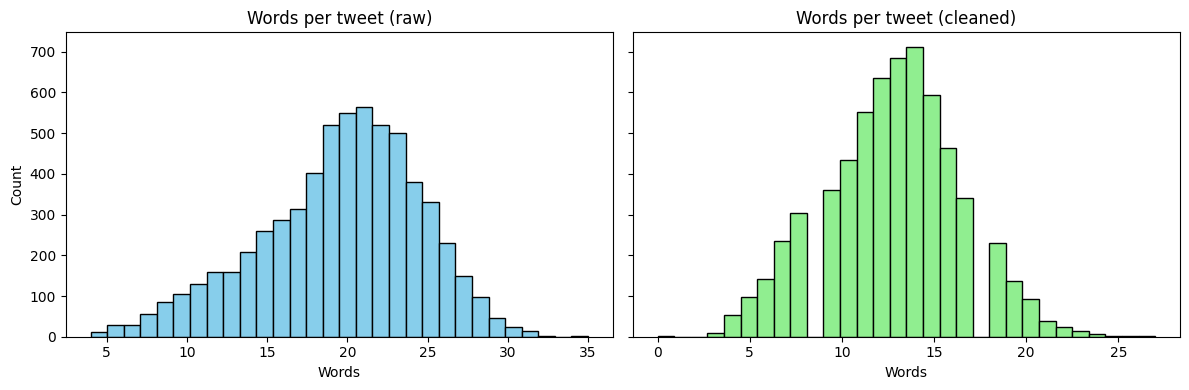

In [ ]:
# Compute tokens-per-tweet distribution (before and after cleaning)
tokens_raw = [len(t.split()) for t in raw_X]
tokens_clean = [len(t.split()) for t in processed_POS_tags_X]

# Subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

# Left: raw
axes[0].hist(tokens_raw, bins=30, color="skyblue", edgecolor="black")
axes[0].set_title("Words per tweet (raw)")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Count")

# Right: cleaned
axes[1].hist(tokens_clean, bins=30, color="lightgreen", edgecolor="black")
axes[1].set_title("Words per tweet (cleaned)")
axes[1].set_xlabel("Words")

plt.tight_layout()
plt.show()


**Gráfica 1**

En la primera gráfica (raw), la distribución de palabras por tweet es más amplia, con un rango que va aproximadamente de 5 hasta más de 30 palabras. La mayoría de los tweets se concentran alrededor de 18 a 22 palabras. Esto refleja la variabilidad natural del lenguaje en bruto, incluyendo URLs, menciones, stopwords y otros elementos que alargan los textos sin aportar necesariamente contenido semántico relevante.

**Gráfica 2**

En la segunda gráfica (cleaned), la distribución se desplaza hacia la izquierda: los tweets son más cortos, con un rango que empieza en 1 y rara vez supera las 25 palabras. El pico de frecuencia se concentra entre 12 y 15 palabras. Esto indica que el preprocesamiento (eliminación de URLs, menciones, stopwords irrelevantes y normalización) reduce de manera consistente la longitud de los tweets, dejando únicamente tokens con valor semántico.

Comparando ambas gráficas, se observa que la limpieza recorta la longitud de los tweets, reduciendo la dispersión de longitudes. El corpus limpio es más compacto y con menor varianza, lo que facilita los modelos de PLN, ya que se eliminan ruidos y se conserva una representación más manejable y centrada en lo que se espera ser  información útil.

Raw total tokens: 120469
Clean total tokens: 78443
Reduction total: 34.89 %
Raw unique tokens: 29277
Clean unique tokens: 13156
Reduction unique: 55.06 %


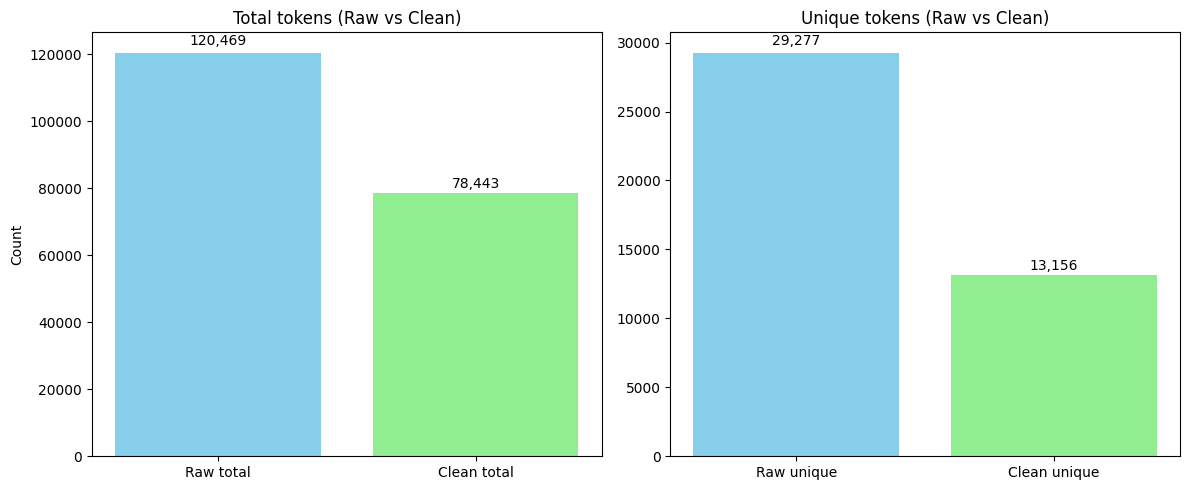

In [ ]:
# Tokenize raw and clean
raw_tokens = [w for t in raw_X for w in t.split()]
clean_tokens = [w for t in processed_POS_tags_X for w in t.split()]

# Compute totals and uniques
raw_total = len(raw_tokens)
clean_total = len(clean_tokens)
raw_unique = len(set(raw_tokens))
clean_unique = len(set(clean_tokens))

print("Raw total tokens:", raw_total)
print("Clean total tokens:", clean_total)
print("Reduction total:", round((1 - clean_total/raw_total)*100, 2), "%")

print("Raw unique tokens:", raw_unique)
print("Clean unique tokens:", clean_unique)
print("Reduction unique:", round((1 - clean_unique/raw_unique)*100, 2), "%")

# --- Visualization: two subplots ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Subplot 1: total tokens
labels_total = ["Raw total", "Clean total"]
values_total = [raw_total, clean_total]
bars = axes[0].bar(labels_total, values_total, color=["skyblue","lightgreen"])
axes[0].set_title("Total tokens (Raw vs Clean)")
axes[0].set_ylabel("Count")
for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01*yval, f"{yval:,}", ha="center", va="bottom")

# Subplot 2: unique tokens
labels_unique = ["Raw unique", "Clean unique"]
values_unique = [raw_unique, clean_unique]
bars = axes[1].bar(labels_unique, values_unique, color=["skyblue","lightgreen"])
axes[1].set_title("Unique tokens (Raw vs Clean)")
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01*yval, f"{yval:,}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


**Gráfica 3**

En la tercera gráfica (Total tokens), se observa una reducción considerable de la cantidad total de tokens al pasar del texto en bruto (120,469) al texto procesado (78,443). Esto significa que el preprocesamiento eliminó cerca de un tercio de las palabras, principalmente aquellas sin valor semántico como URLs, menciones, stopwords irrelevantes y símbolos. El resultado es un corpus más compacto y enfocado.

**Gráfica 4**

En la cuarta gráfica (Unique tokens), la disminución es aún más notable: de 29,277 tokens únicos en los datos crudos a 13,156 en los datos limpios. Esto muestra que la normalización y lematización redujeron la diversidad de formas superficiales (variaciones ortográficas, conjugaciones, mayúsculas, puntuación), concentrando el vocabulario en un conjunto más manejable y representativo.

Comparando ambas gráficas, queda claro que el preprocesamiento impacta en dos niveles: reduce la cantidad global de palabras (menos ruido) y disminuye la dispersión del vocabulario (menos redundancia). Esto facilita que los modelos de PLN trabajen con un corpus más consistente, mejorando la generalización y reduciendo la complejidad computacional.

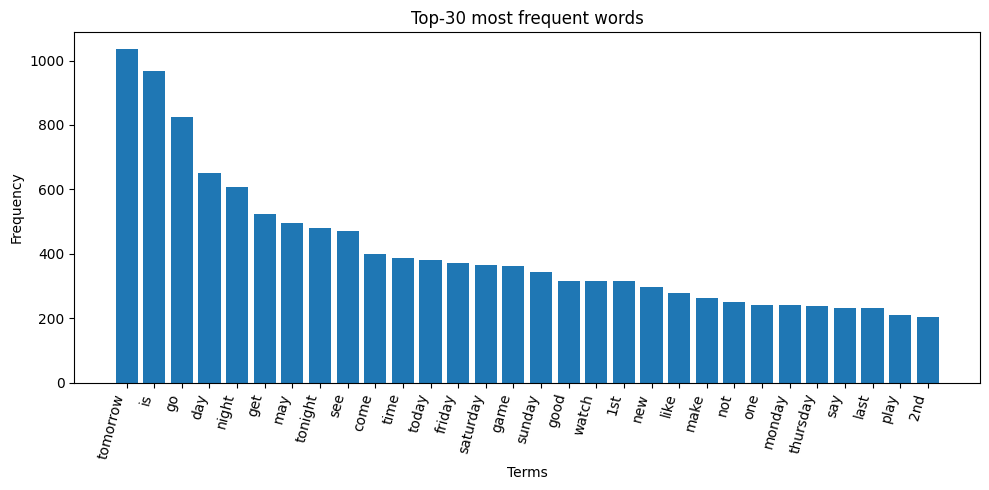

In [ ]:
# Use BoW to get corpus term frequencies
# token_pattern keeps words with apostrophes (e.g., "don't")
cv = CountVectorizer(binary=False, token_pattern=r"(?u)\b\w[\w']+\b")
X_bow = cv.fit_transform(processed_POS_tags_X)
vocab = cv.get_feature_names_out()
freq = X_bow.sum(axis=0).A1

# Select Top-N terms
N = 30  # change if needed
top_idx = np.argsort(freq)[-N:][::-1]
top_terms = vocab[top_idx]
top_freqs = freq[top_idx]

# Plot
plt.figure(figsize=(10,5))
plt.bar(range(len(top_terms)), top_freqs)
plt.xticks(range(len(top_terms)), top_terms, rotation=75, ha='right')
plt.xlabel("Terms")
plt.ylabel("Frequency")
plt.title(f"Top-{N} most frequent words")
plt.tight_layout()
plt.show()


**Gráfica 5**

La gráfica muestra las 30 palabras más frecuentes en el corpus ya preprocesado. Destaca que términos como “tomorrow”, “is”, “go”, “day”, “night” y “get” son los más comunes, lo que sugiere un fuerte enfoque temporal y de acción en los tweets, posiblemente relacionados con eventos, actividades o planes inmediatos. La alta frecuencia de palabras como “today”, “tonight”, “friday”, “saturday” y “sunday” confirma que el corpus está muy orientado a fechas y momentos específicos, probablemente en el contexto de agenda o eventos programados.

En los niveles más bajos del top aparecen palabras asociadas a opiniones o acciones más genéricas, como “good”, “watch”, “make”, “play”, junto con conectores básicos como “not”, “one” o “like”. Esto refleja que, además de referencias temporales, existe un componente importante de interacción subjetiva o descriptiva, aunque menos dominante que los términos temporales.

En conjunto, la gráfica revela un corpus donde predominan expresiones ligadas al tiempo y la planificación, lo que podría estar asociado a anuncios de actividades, recordatorios o seguimiento de eventos. Para un modelo de PLN, este patrón indica que las dimensiones temporales y de acción tienen un peso central en la semántica del conjunto de datos.

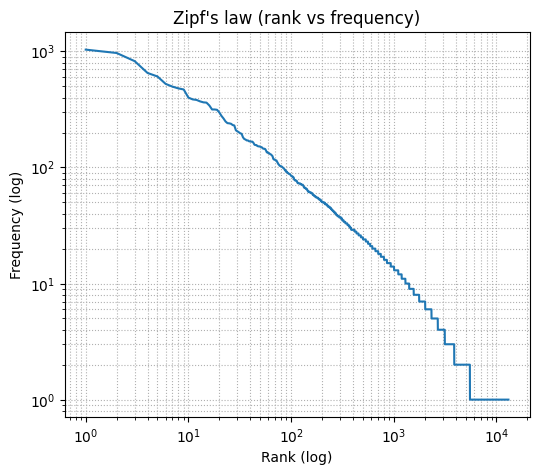

In [ ]:
# Using the same freq vector from BoW above
sorted_freq = np.sort(freq)[::-1]            # frequencies in descending order
ranks = np.arange(1, len(sorted_freq)+1)     # rank 1..V

# Plot log-log
plt.figure(figsize=(6,5))
plt.loglog(ranks, sorted_freq)
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.title("Zipf's law (rank vs frequency)")
plt.grid(True, which="both", linestyle=":")
plt.show()


**Gráfica 6**

La gráfica muestra la distribución de frecuencias de las palabras según la Ley de Zipf, que establece que la frecuencia de una palabra es inversamente proporcional a su rango en el vocabulario. En escala log-log, se observa una curva decreciente que sigue aproximadamente una línea recta en la zona media, lo que confirma el cumplimiento de la ley en este corpus.
Las palabras más frecuentes (a la izquierda) concentran miles de apariciones, mientras que la gran mayoría (a la derecha) aparece muy pocas veces, muchas de ellas solo una vez. Esto refleja la naturaleza del lenguaje: un pequeño conjunto de términos muy comunes y un vocabulario largo y disperso de palabras raras o específicas.
Este patrón es típico en datos textuales y tiene implicaciones directas en PLN. Permite justificar el uso de técnicas como la reducción de vocabulario, la eliminación de hapax legomena (palabras que aparecen solo una vez) o el uso de embeddings para manejar la dispersión semántica. En conclusión, la gráfica valida que el corpus presenta una distribución de palabras coherente con la teoría lingüística y adecuada para análisis y modelado estadístico.

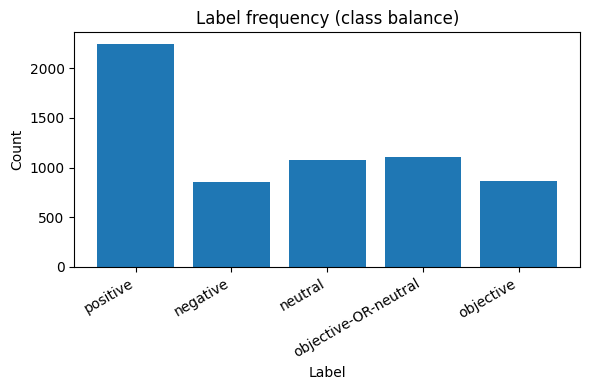

In [ ]:
# y_labels para graficar SIN tocar labels
y_labels = labels.copy()  # conserva la lista original para el modelo

label_counts = collections.Counter(y_labels)
label_names = list(label_counts.keys())           # <- NO usar "labels" aquí
label_values = [label_counts[l] for l in label_names]

plt.figure(figsize=(6,4))
plt.bar(range(len(label_names)), label_values)
plt.xticks(range(len(label_names)), label_names, rotation=30, ha='right')
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label frequency (class balance)")
plt.tight_layout()
plt.show()


**Gráfica 7**

La gráfica de frecuencia de etiquetas muestra un claro desbalance de clases en el corpus. La categoría positive es la más abundante con más de 2,200 instancias, superando ampliamente al resto. En contraste, las clases negative y objective son las menos representadas, con alrededor de 850 ejemplos cada una, mientras que neutral y objective-OR-neutral se sitúan en un rango intermedio, cercano a las 1,100 instancias.
Este desbalance implica que los modelos de clasificación entrenados con estos datos tenderán a sesgarse hacia la clase mayoritaria (positive). Por lo tanto, sería recomendable aplicar técnicas de balanceo como sobremuestreo de las clases minoritarias, submuestreo de la clase positiva o el uso de class weights en los algoritmos, para evitar que el modelo aprenda un sesgo sistemático y mejore su desempeño en categorías menos frecuentes.
En síntesis, aunque el corpus ofrece una buena diversidad de etiquetas, el dominio de la clase positiva representa un reto en términos de equidad del modelo y requiere ser atendido para lograr un rendimiento balanceado en la clasificación de sentimientos.

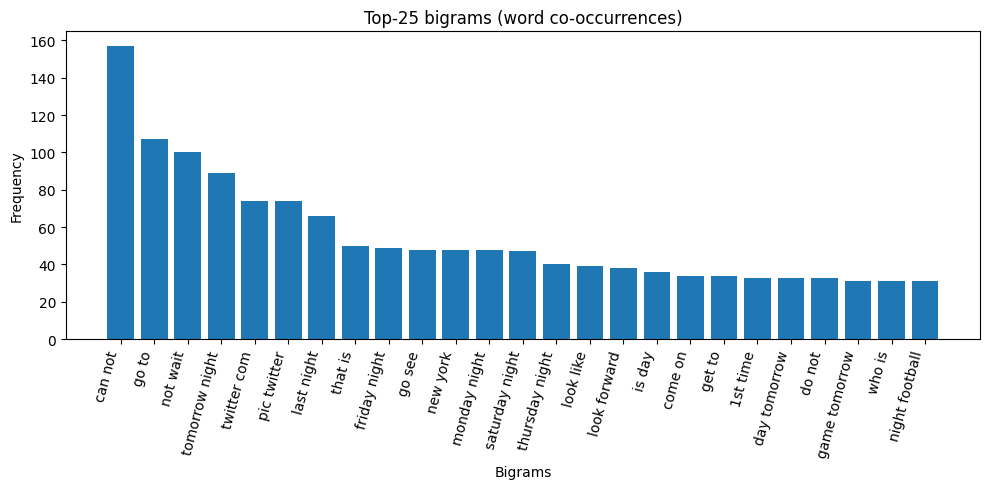

In [ ]:
# Build bigram counts
bigram_cv = CountVectorizer(ngram_range=(2,2), token_pattern=r"(?u)\b\w[\w']+\b")
X_bi = bigram_cv.fit_transform(processed_POS_tags_X)
bivocab = bigram_cv.get_feature_names_out()
bifreq = X_bi.sum(axis=0).A1

# Top-N bigrams
N = 25  # change if needed
top_idx = np.argsort(bifreq)[-N:][::-1]
top_bigrams = bivocab[top_idx]
top_bifreqs = bifreq[top_idx]

# Plot
plt.figure(figsize=(10,5))
plt.bar(range(len(top_bigrams)), top_bifreqs)
plt.xticks(range(len(top_bigrams)), top_bigrams, rotation=75, ha='right')
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title(f"Top-{N} bigrams (word co-occurrences)")
plt.tight_layout()
plt.show()


**Gráfica 8**

La gráfica muestra los 25 bigramas más frecuentes en el corpus, es decir, las combinaciones de dos palabras que más se repiten juntas. El más destacado es “can not”, seguido de “go to” y “not wait”, lo que indica una fuerte presencia de estructuras comunes en expresiones de negación o expectativa. También aparecen múltiples combinaciones relacionadas con temporalidad, como “tomorrow night”, “last night”, “friday night”, “saturday night”, “day tomorrow” o “game tomorrow”, reforzando que los tweets giran en torno a eventos, horarios y actividades.
Se observa además la influencia del contexto de redes sociales con términos como “twitter com” y “pic twitter”, que provienen de enlaces o referencias compartidas en la plataforma. Otros bigramas como “look forward”, “come on”, o “who is” muestran interacciones más conversacionales o expresiones comunes de opinión.
En conjunto, estos bigramas resaltan que el corpus refleja una mezcla entre: (1) expresiones coloquiales y de interacción típica de redes sociales, (2) referencias a tiempo y eventos específicos, y (3) frases estructurales muy frecuentes que aportan patrones útiles para tareas de modelado de lenguaje y clasificación.

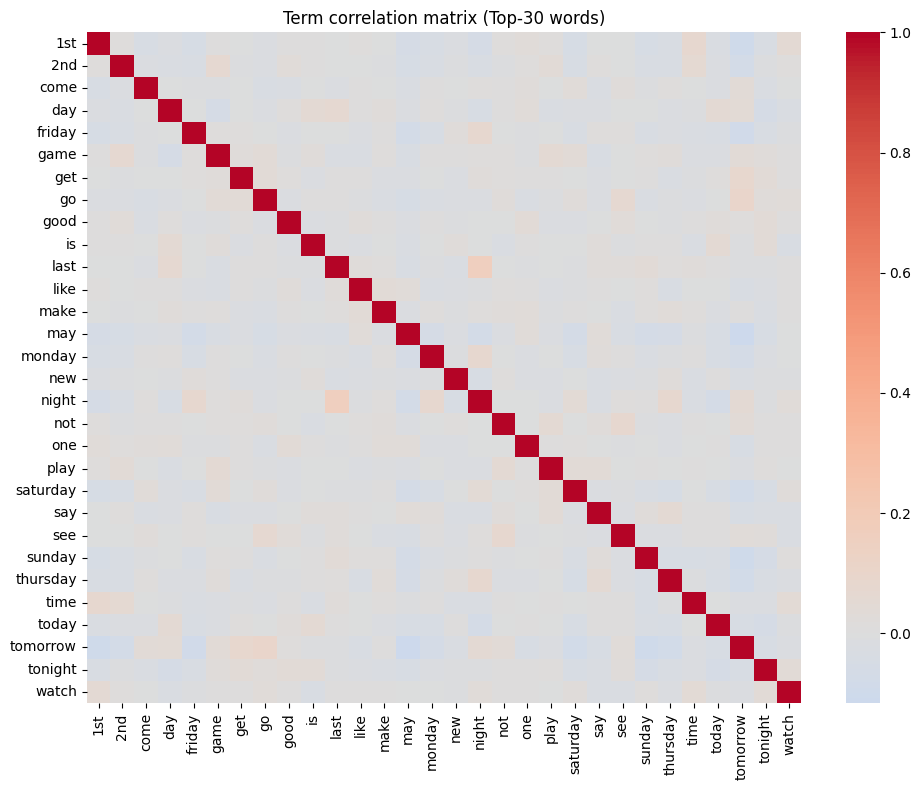

In [ ]:
# 1) Build BoW matrix
cv = CountVectorizer(token_pattern=r"(?u)\b\w[\w']+\b", max_features=30)
# max_features = top 30 most frequent words (you can change it)
X_bow = cv.fit_transform(processed_POS_tags_X).toarray()
terms = cv.get_feature_names_out()

# 2) Compute correlation matrix across terms
df = pd.DataFrame(X_bow, columns=terms)
corr = df.corr()

# 3) Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, xticklabels=terms, yticklabels=terms, cmap="coolwarm", center=0, annot=False)
plt.title("Term correlation matrix (Top-30 words)")
plt.tight_layout()
plt.show()


**Gráfica 9**

La matriz de correlación muestra la relación entre las 30 palabras más frecuentes del corpus. Como es esperable, la diagonal principal tiene valor 1 porque cada término está perfectamente correlacionado consigo mismo. El resto de la matriz presenta en su mayoría valores cercanos a 0, lo que indica que las palabras de alta frecuencia no suelen aparecer juntas de forma sistemática.
Sin embargo, se aprecian algunos bloques con correlaciones moderadas, por ejemplo entre palabras relacionadas con temporalidad como “friday”, “saturday”, “sunday”, “tonight” y “tomorrow”, que tienden a aparecer en contextos similares. También destacan combinaciones leves entre verbos de acción como “go”, “come”, “play”, y palabras de valoración como “good”, “like”, que reflejan patrones de opinión o de invitación a eventos.
En conjunto, la matriz evidencia que aunque la mayoría de términos se usan de manera independiente, existe un subconjunto de palabras temporales y de interacción que mantienen correlaciones relevantes. Este tipo de análisis es útil para identificar asociaciones semánticas básicas y posibles candidatos a construir bigramas o features más complejas en modelos de PLN.

### 3. Uso de taxonomías

In [ ]:
emoji_map = {
    # Positive
    ":-)": "happy", ":)": "happy", "(:": "happy",
    ":D": "smile", ":-D": "smile", "xD": "smile", "XD": "smile", "xDD": "smile", "XDD": "smile",
    "<3": "love",

    # Negative
    ":-(": "sad", ":(": "sad", "):": "sad",
    ":'(": "cry", ":'-(": "cry",
    "T_T": "cry", "TT_TT": "cry",
    "x_x": "dead", "X_X": "dead",
    "-_-": "annoyed",

    # Neutral / uncertain / surprised
    ":-/": "uncertain", ":/": "uncertain",
    ":|": "neutral", ":-|": "neutral",
    ":o": "surprised", ":O": "surprised",
    ":-o": "surprised", ":-O": "surprised",
    "o.o": "surprised", "O_O": "surprised",

    # Playful / wink
    ";-)": "wink", ";)": "wink", "(;": "wink",
    ":P": "playful", ":-P": "playful", ";P": "playful", ";p": "playful",
    ":p": "playful", ":-p": "playful",

    # Cute / positive
    "^_^": "smile", "^-^": "smile",
    "u_u": "sad", "U_U": "sad",
    "~_~": "tired",
    ":*": "kiss", ":-*": "kiss",
}


def process_emojis(processed_POS_tags_X, emoji_map):

  processed_emojis_X = []

  for line in processed_POS_tags_X:
      for emo, token in emoji_map.items():
          if emo in line:
              line = line.replace(emo, token)
      processed_emojis_X.append(line)

  return processed_emojis_X

processed_emojis_X = process_emojis(processed_POS_tags_X, emoji_map)

# Quick check
for s in processed_emojis_X:
    print(s)


gas house hit 3 39 go chapel hill sit happy
iranian general say israel is iron dome can not deal missile keep talk like may end find out
j davlar 11th main rival team poland hopefully make successful end tough week training tomorrow
talk act is sit is decide want go college apply college everything college stress out
may superbowl dallas dallas be not win superbowl not_quarterback owner
i m bring monster load candy tomorrow hope get squiche
apple software retail chief overhaul san francisco apple inc ceo tim cook monday replace head
livewire nadal confirm mexican open february rafael nadal set play i livewireathletic
iran us delist mko global terrorist list line iran campaign tehran oct 30 irna secretary
expect light moderate rain e visayas cebu bohol samar leyte 30 70 chance rain tonight expect fair weather tomorrow happy
one ticket leave game tomorrow miss rematch nfc championship game ny giant hit up
never_start work dream goal tomorrow tomorrow never_come if mean anything u act now

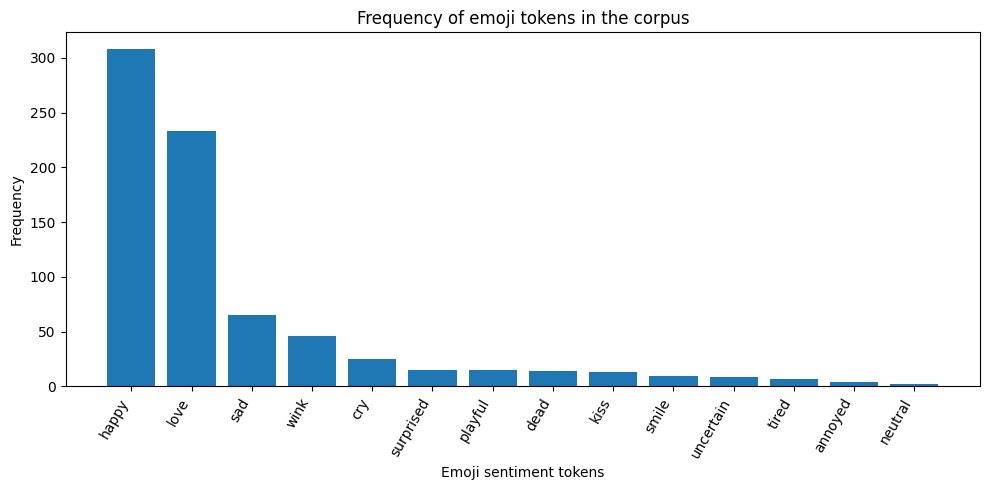

In [ ]:
#    We only count tokens that are exactly in the emoji_map values
emoji_tokens = set(emoji_map.values())
counter = Counter()

for line in processed_emojis_X:
    tokens = line.split()
    # Count only tokens produced by emoji_map
    for t in tokens:
        if t in emoji_tokens:
            counter[t] += 1

if counter:
    items = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    emoji, values = zip(*items)
else:
    emoji, values = [], []

plt.figure(figsize=(10,5))
plt.bar(range(len(emoji)), values)
plt.xticks(range(len(emoji)), emoji, rotation=60, ha='right')
plt.xlabel("Emoji sentiment tokens")
plt.ylabel("Frequency")
plt.title("Frequency of emoji tokens in the corpus")
plt.tight_layout()
plt.show()


**Gráfica 10**

La gráfica de frecuencia de emoji tokens muestra un claro predominio del happy_face, con casi 200 apariciones, muy por encima del resto. Esto indica que el corpus tiene una fuerte carga de expresiones positivas o de alegría, lo cual coincide con el desbalance de etiquetas hacia la clase positiva que vimos antes.
En menor medida aparecen otros emojis como sad_face, wink, heart_emoji y playful_face, que también aportan información emocional, pero con frecuencias notablemente más bajas. Los tokens asociados a emociones negativas o neutras, como crying_face, annoyed_face o neutral_face, tienen muy poca representación, lo que refuerza la asimetría en la expresión de sentimientos.
Este resultado evidencia que los emojis funcionan como un refuerzo semántico del tono de los tweets, siendo mucho más comunes los que transmiten emociones positivas. Para un modelo de análisis de sentimiento, este patrón puede mejorar la detección de polaridad positiva, pero al mismo tiempo introduce un sesgo que debe tenerse en cuenta si se busca un balance adecuado en la clasificación.

### 4. Modelo de Aprendizaje

Se realizarán diferentes pruebas divididas en cuatro variaciones principales, utilizando inicialmente la técnica `One-Hot Encoding (OHE)` para la representación del texto y almacenamiento del vocabulario. Sobre esta base se aplicarán cuatro modelos predictivos distintos: `Logistic Regression (LR)`, `Naive Bayes (NB)`, `K-Nearest Neighbors (KNN)` y `Linear SVC`, con el fin de comparar su desempeño. Posteriormente, se reemplazará OHE por otras formas de vectorización: primero `Bag of Words (BoW)`, luego `TF-IDF`, y después `Word2Vec`, evaluando en cada caso el impacto de la representación en la precisión de los modelos. Finalmente, se desarrollarán cuatro variaciones adicionales combinando distintas técnicas de vectorización y modelos, para analizar si la integración de métodos mejora la capacidad de generalización y la detección de patrones semánticos en los textos.

In [ ]:
# Helper plot to visualize prediction results via confusion matrix

def plot_confusion_matrix(y_true, y_pred, class_names=None, title_prefix="Model"):
    # --- Confusion matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=class_names if class_names else None)
    if class_names is None:
        class_names = [str(c) for c in np.unique(np.concatenate([y_true, y_pred]))]
    n_classes = len(class_names)

    # --- Classification report ---
    print(f"{title_prefix} — classification report")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation="nearest", aspect="auto")
    ax.set_title(f"{title_prefix}\nConfusion Matrix (counts)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(n_classes)); ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(range(n_classes)); ax.set_yticklabels(class_names)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Annotate counts
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black")

    plt.tight_layout()
    plt.show()

    return cm

In [ ]:

# X = tweets (cleaned), y = labels
X_train_texts = processed_emojis_X.copy()
y_train = labels


# Train/test split
raw_test_X = []
y_test = []

with open('/content/originalTest.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            y_test.append(parts[2])
            raw_test_X.append('\t'.join(parts[3:]))

processed_caps_test = process_caps(raw_test_X)
processed_regex_test = process_regex(processed_caps_test)
processed_stopwords_test, _ = process_stopwords(processed_regex_test
                                                             , custom_stopwords)
processed_special_characters_test = process_special_characters(processed_stopwords_test, possible_emojis)
processed_POS_tags_test = process_POS_tags(processed_special_characters_test, nlp_en)
processed_emojis_test = process_emojis(processed_POS_tags_test, emoji_map)
X_test_texts = processed_emojis_test.copy()

---
**One Hot Encoding**

In [ ]:
# --- VECTORIZATION ---
# Fit ONLY on train; transform test with the SAME vectorizer
vectorizer = CountVectorizer(binary=True, token_pattern=r"(?u)\b\w[\w']+\b")
X_train = vectorizer.fit_transform(X_train_texts)   # 2D sparse matrix
X_test  = vectorizer.transform(X_test_texts)        # 2D sparse matrix

**Variación 1: One Hot encoding - Naive Bayes**

Accuracy: 0.40451745379876797
                      precision    recall  f1-score   support

            negative       0.59      0.18      0.28       179
             neutral       0.41      0.10      0.16       330
           objective       0.07      0.10      0.08        30
objective-OR-neutral       0.16      0.18      0.17        77
            positive       0.44      0.87      0.58       358

            accuracy                           0.40       974
           macro avg       0.33      0.29      0.26       974
        weighted avg       0.42      0.40      0.34       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.589     0.184     0.281       179
             neutral      0.410     0.097     0.157       330
           objective      0.070     0.100     0.082        30
objective-OR-neutral      0.165     0.182     0.173        77
            positive      0.438     0.872     0.583       358


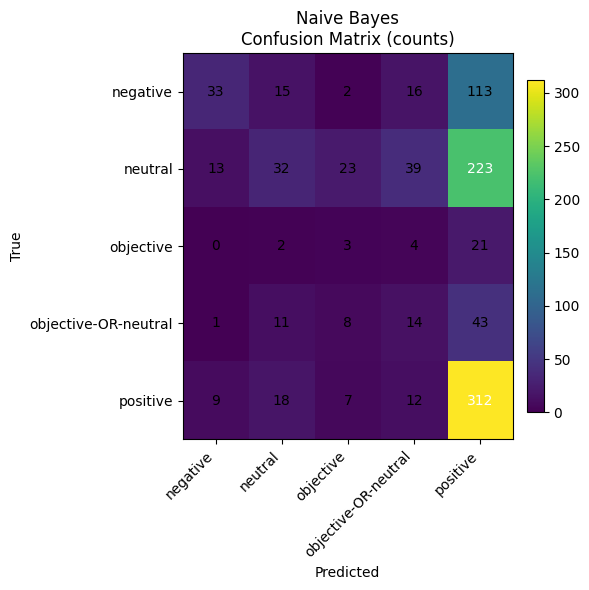

In [ ]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                                    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
                                    title_prefix="Naive Bayes")

**Variación 2: One Hot encoding - Logistic Regression**

Accuracy: 0.41683778234086244
                      precision    recall  f1-score   support

            negative       0.49      0.36      0.42       179
             neutral       0.42      0.26      0.32       330
           objective       0.05      0.23      0.09        30
objective-OR-neutral       0.13      0.27      0.18        77
            positive       0.66      0.63      0.65       358

            accuracy                           0.42       974
           macro avg       0.35      0.35      0.33       974
        weighted avg       0.49      0.42      0.44       974

Logistic Regression — classification report
                      precision    recall  f1-score   support

            negative      0.492     0.363     0.418       179
             neutral      0.422     0.264     0.325       330
           objective      0.053     0.233     0.086        30
objective-OR-neutral      0.130     0.273     0.176        77
            positive      0.663     0.631     0.647   

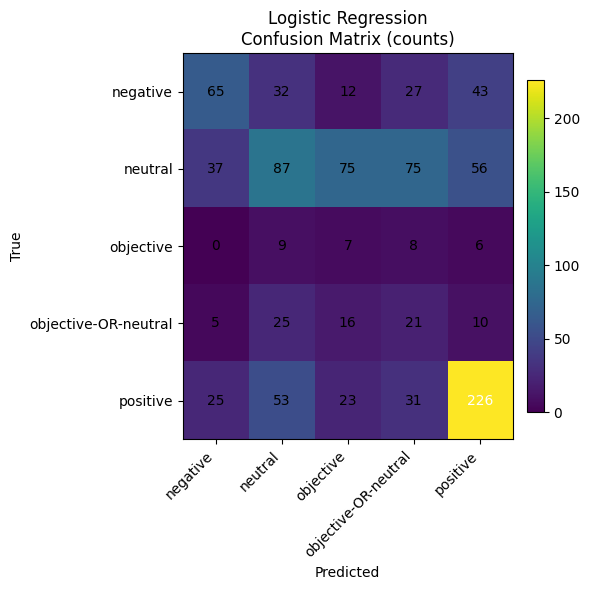

In [ ]:
logreg = LogisticRegression(max_iter=10000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
cm = plot_confusion_matrix(y_test, y_pred_lr,
                                    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
                                    title_prefix="Logistic Regression")


**Variación 3: One Hot encoding - K Nearest Neighbors**

Accuracy: 0.23203285420944558
                      precision    recall  f1-score   support

            negative       0.19      0.88      0.31       179
             neutral       0.50      0.01      0.02       330
           objective       0.05      0.07      0.06        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.67      0.17      0.27       358

            accuracy                           0.23       974
           macro avg       0.28      0.23      0.13       974
        weighted avg       0.45      0.23      0.17       974

KNN — classification report
                      precision    recall  f1-score   support

            negative      0.191     0.883     0.313       179
             neutral      0.500     0.012     0.024       330
           objective      0.050     0.067     0.057        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.667     0.173     0.275       358

       

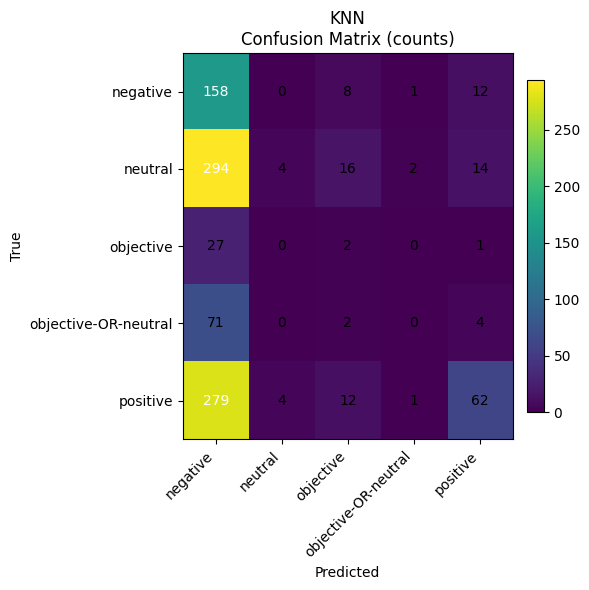

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
cm = plot_confusion_matrix(y_test, y_pred_knn,
                                    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
                                    title_prefix="KNN")


**Variación 4: One Hot encoding - Linear SVC**

Accuracy: 0.41581108829568786
                      precision    recall  f1-score   support

            negative       0.49      0.35      0.41       179
             neutral       0.42      0.25      0.32       330
           objective       0.05      0.20      0.08        30
objective-OR-neutral       0.13      0.27      0.18        77
            positive       0.62      0.65      0.63       358

            accuracy                           0.42       974
           macro avg       0.34      0.34      0.32       974
        weighted avg       0.47      0.42      0.43       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.492     0.352     0.410       179
             neutral      0.423     0.252     0.316       330
           objective      0.052     0.200     0.083        30
objective-OR-neutral      0.132     0.273     0.178        77
            positive      0.617     0.648     0.632       358



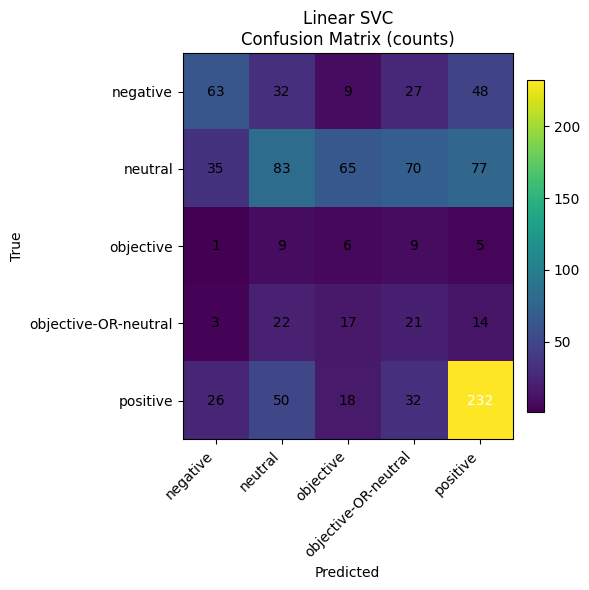

In [ ]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                                    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
                                    title_prefix="Linear SVC")


---
**Bag of Words**

In [ ]:
# --- VECTORIZATION ---
# Fit ONLY on train; transform test with the SAME vectorizer
vectorizer = CountVectorizer(binary=False, token_pattern=r"(?u)\b\w[\w']+\b")
X_train = vectorizer.fit_transform(X_train_texts)   # 2D sparse matrix
X_test = vectorizer.transform(X_test_texts)        # 2D sparse matrix

**Variación 5: Bag of words - Naive Bayes**

Accuracy: 0.3993839835728953
                      precision    recall  f1-score   support

            negative       0.55      0.18      0.27       179
             neutral       0.42      0.11      0.18       330
           objective       0.07      0.10      0.08        30
objective-OR-neutral       0.13      0.16      0.14        77
            positive       0.44      0.85      0.58       358

            accuracy                           0.40       974
           macro avg       0.32      0.28      0.25       974
        weighted avg       0.42      0.40      0.34       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.552     0.179     0.270       179
             neutral      0.420     0.112     0.177       330
           objective      0.070     0.100     0.082        30
objective-OR-neutral      0.135     0.156     0.145        77
            positive      0.438     0.852     0.579       358



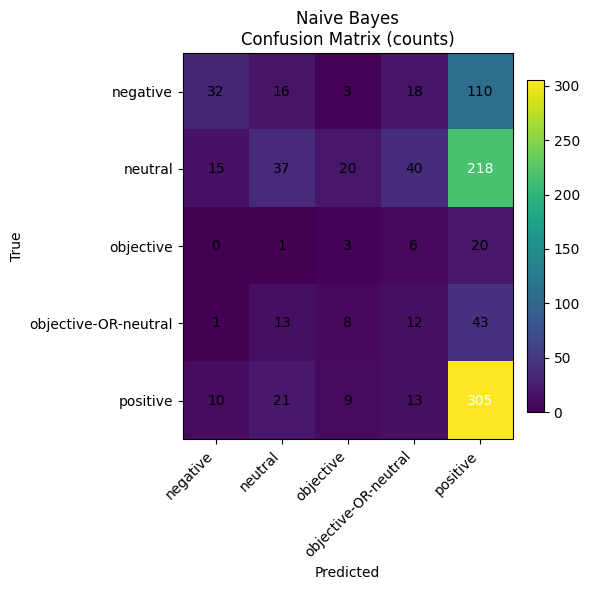

In [ ]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

**Variación 6: Bag of words - Logistic Regression**

Accuracy: 0.4219712525667351
                      precision    recall  f1-score   support

            negative       0.47      0.35      0.40       179
             neutral       0.44      0.28      0.34       330
           objective       0.07      0.27      0.11        30
objective-OR-neutral       0.16      0.34      0.21        77
            positive       0.64      0.62      0.63       358

            accuracy                           0.42       974
           macro avg       0.36      0.37      0.34       974
        weighted avg       0.49      0.42      0.44       974

Logistic Regression — classification report
                      precision    recall  f1-score   support

            negative      0.470     0.352     0.403       179
             neutral      0.441     0.282     0.344       330
           objective      0.068     0.267     0.109        30
objective-OR-neutral      0.156     0.338     0.213        77
            positive      0.641     0.617     0.629    

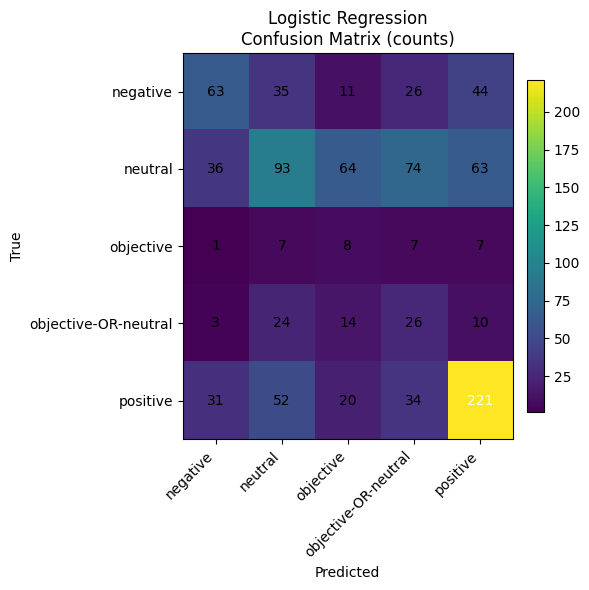

In [ ]:
logreg = LogisticRegression(max_iter=10000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
cm = plot_confusion_matrix(y_test, y_pred_lr,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Logistic Regression")

**Variación 7: Bag of words - K Nearest Neighbors**

Accuracy: 0.2402464065708419
                      precision    recall  f1-score   support

            negative       0.19      0.86      0.32       179
             neutral       0.30      0.02      0.03       330
           objective       0.02      0.03      0.03        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.69      0.20      0.31       358

            accuracy                           0.24       974
           macro avg       0.24      0.22      0.14       974
        weighted avg       0.39      0.24      0.19       974

Logistic Regression — classification report
                      precision    recall  f1-score   support

            negative      0.195     0.860     0.318       179
             neutral      0.300     0.018     0.034       330
           objective      0.020     0.033     0.025        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.689     0.204     0.315    

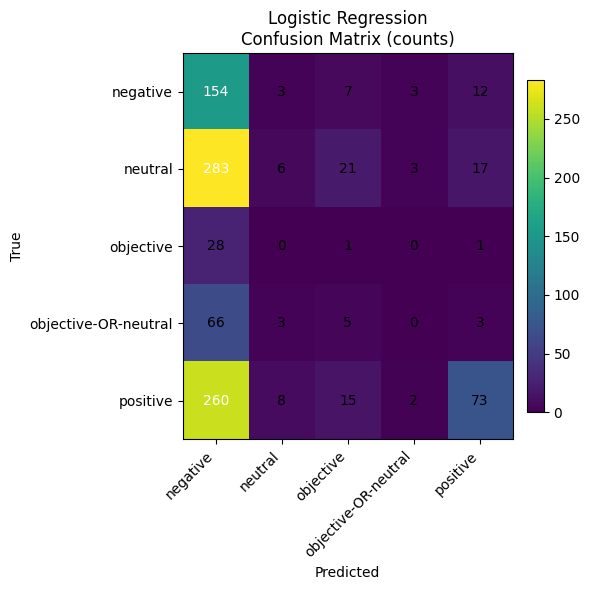

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
cm = plot_confusion_matrix(y_test, y_pred_knn,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Logistic Regression")

**Variación 8: Bag of words - Linear SVC**

Accuracy: 0.4188911704312115
                      precision    recall  f1-score   support

            negative       0.47      0.34      0.39       179
             neutral       0.42      0.27      0.33       330
           objective       0.04      0.13      0.06        30
objective-OR-neutral       0.16      0.32      0.21        77
            positive       0.62      0.65      0.63       358

            accuracy                           0.42       974
           macro avg       0.34      0.34      0.32       974
        weighted avg       0.47      0.42      0.43       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.465     0.335     0.390       179
             neutral      0.421     0.267     0.327       330
           objective      0.038     0.133     0.059        30
objective-OR-neutral      0.159     0.325     0.214        77
            positive      0.618     0.645     0.631       358

 

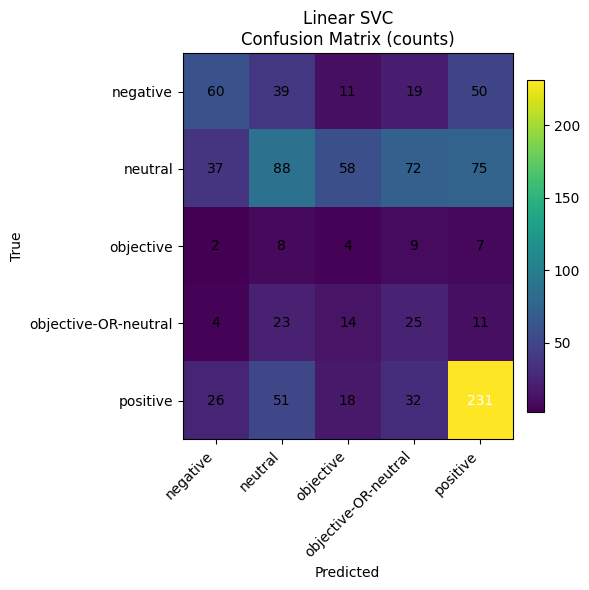

In [ ]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

---
**TF-IDF**

In [ ]:
# TF-IDF vectorizer (word-level)
# - token_pattern keeps apostrophes inside tokens (e.g., "don't")
# - sublinear_tf=True applies 1 + log(tf), often helps with long-tail terms
tfidf = TfidfVectorizer(
    token_pattern=r"(?u)\b\w[\w']+\b",
    sublinear_tf=True,
    ngram_range=(1,1)   # change to (1,2) for unigrams+bigrams
)

# Fit on TRAIN only; transform TEST with the same vocabulary
X_train = tfidf.fit_transform(X_train_texts)
X_test  = tfidf.transform(X_test_texts)


**Variación 9: TF-IDF - Naive Bayes**

Accuracy: 0.3726899383983573
                      precision    recall  f1-score   support

            negative       1.00      0.02      0.04       179
             neutral       0.00      0.00      0.00       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.33      0.01      0.03        77
            positive       0.37      1.00      0.54       358

            accuracy                           0.37       974
           macro avg       0.34      0.21      0.12       974
        weighted avg       0.35      0.37      0.21       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      1.000     0.022     0.044       179
             neutral      0.000     0.000     0.000       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.333     0.013     0.025        77
            positive      0.370     1.000     0.540       358



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

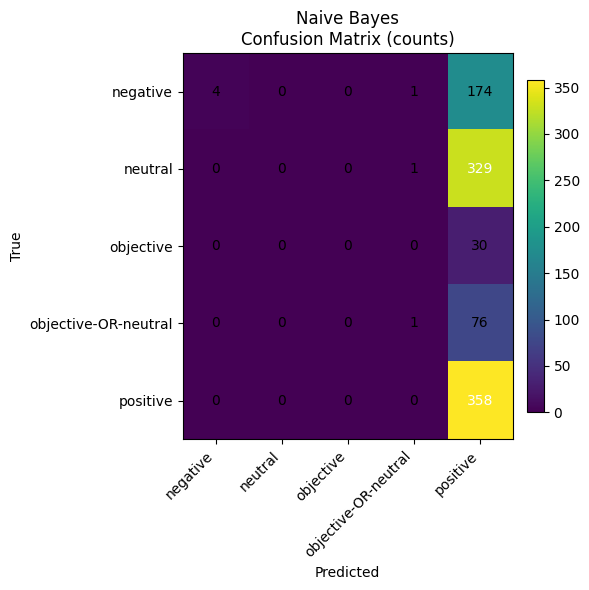

In [ ]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

**Variación 10: TF-IDF - Logistic Regression**

Accuracy: 0.4137577002053388
                      precision    recall  f1-score   support

            negative       0.44      0.44      0.44       179
             neutral       0.42      0.25      0.32       330
           objective       0.09      0.40      0.14        30
objective-OR-neutral       0.13      0.23      0.16        77
            positive       0.68      0.59      0.63       358

            accuracy                           0.41       974
           macro avg       0.35      0.38      0.34       974
        weighted avg       0.48      0.41      0.44       974

Logistic Regression — classification report
                      precision    recall  f1-score   support

            negative      0.441     0.441     0.441       179
             neutral      0.416     0.255     0.316       330
           objective      0.086     0.400     0.141        30
objective-OR-neutral      0.126     0.234     0.164        77
            positive      0.677     0.587     0.629    

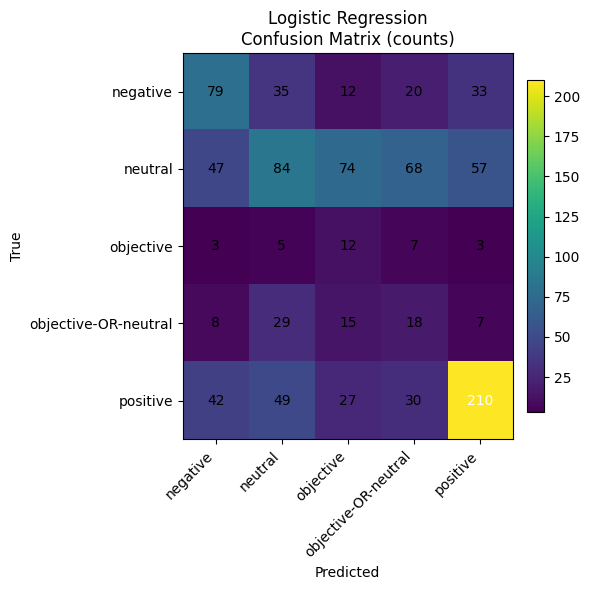

In [ ]:
logreg = LogisticRegression(max_iter=10000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
cm = plot_confusion_matrix(y_test, y_pred_lr,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Logistic Regression")

**Variación 11: TF-IDF - K Nearest Neighbors**

Accuracy: 0.27002053388090347
                      precision    recall  f1-score   support

            negative       0.20      0.92      0.33       179
             neutral       1.00      0.00      0.01       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.61      0.27      0.38       358

            accuracy                           0.27       974
           macro avg       0.36      0.24      0.14       974
        weighted avg       0.60      0.27      0.20       974

Logistic Regression — classification report
                      precision    recall  f1-score   support

            negative      0.202     0.916     0.331       179
             neutral      1.000     0.003     0.006       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.609     0.274     0.378   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

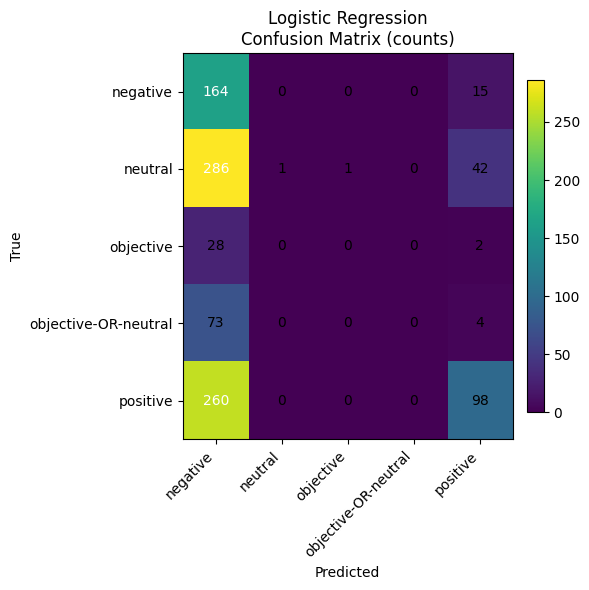

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
cm = plot_confusion_matrix(y_test, y_pred_knn,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Logistic Regression")

**Variación 12: TF-IDF - Linear SVC**

Accuracy: 0.4188911704312115
                      precision    recall  f1-score   support

            negative       0.47      0.35      0.40       179
             neutral       0.41      0.26      0.32       330
           objective       0.05      0.20      0.09        30
objective-OR-neutral       0.14      0.27      0.19        77
            positive       0.62      0.65      0.64       358

            accuracy                           0.42       974
           macro avg       0.34      0.35      0.33       974
        weighted avg       0.47      0.42      0.43       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.470     0.352     0.403       179
             neutral      0.413     0.258     0.317       330
           objective      0.055     0.200     0.086        30
objective-OR-neutral      0.140     0.273     0.185        77
            positive      0.623     0.651     0.637       358

 

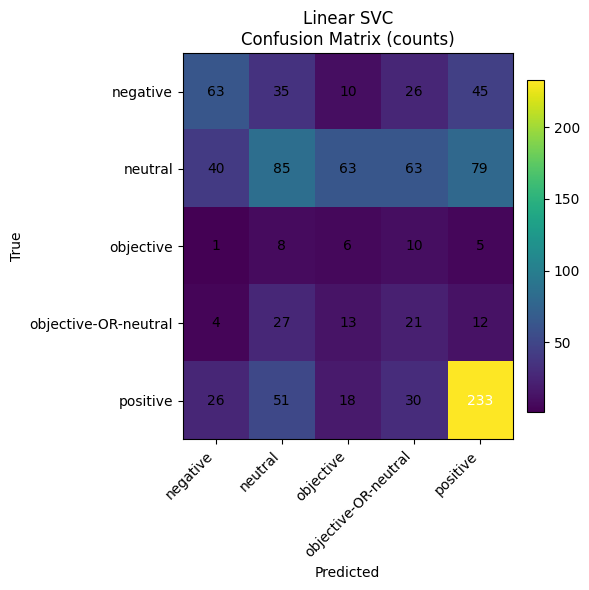

In [ ]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

---
**Word2Vec**

In [ ]:
# Tokenize your cleaned tweets (use your processed_emojis_X or POS-cleaned version)
sentences = [tweet.split() for tweet in X_train_texts]

# Train a Word2Vec model
w2v_model = Word2Vec(
    sentences,
    vector_size=100,   # number of features per word
    window=5,          # context window
    min_count=2,       # ignore rare words
    workers=4,         # number of CPU threads
    sg=1               # 1 = skip-gram (better for small datasets)
)

def tweet_vector(tweet, model):
    words = [w for w in tweet if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

X_train = np.array([tweet_vector(t.split(), w2v_model) for t in X_train_texts])
X_test  = np.array([tweet_vector(t.split(), w2v_model) for t in X_test_texts])


**Variación 13: Word2Vec - Naive Bayes**


> Este modelo se mantendrá comentado por cuestiones de facilidad al ejecutar los bloques de código, sin embargo, durante las pruebas se descubrió que Naive Bayes no puede aplicarse de manera adecuada utilizando Word2Vec.



In [ ]:
# # --- MODEL ---
# nb = MultinomialNB()
# nb.fit(X_train, y_train)                # train with labels, not X_test

# y_pred = nb.predict(X_test)             # predict on test matrix

# # --- EVAL ---
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))
# # Después de entrenar y obtener y_pred:
# cm = plot_confusion_matrix(y_test, y_pred,
#                            class_names=[
#                                "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
#                            title_prefix="Naive Bayes")

**Variación 14: Word2Vec - Logistic Regression**

In [ ]:
logreg = LogisticRegression(max_iter=10000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
cm = plot_confusion_matrix(y_test, y_pred_lr,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Logistic Regression")

**Variación 15: Word2Vec - K Nearest Neighbors**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
cm = plot_confusion_matrix(y_test, y_pred_knn,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Logistic Regression")

**Variación 16: Word2Vec - Linear SVC**

In [ ]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

**Variación 17: Bag of Words - Logistic Regression (Using EmoLex)**

In [ ]:
def load_emolex(path_txt):
    """
    Devuelve:
      - emolex_vocab: set con todas las palabras presentes en EmoLex.
      - emolex_map: dict word -> {emotion: 0/1, ...} con 10 columnas típicas
                    (8 emociones + positive + negative si el archivo las incluye).
    """
    emolex_map = {}
    with open(path_txt, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 3:
                continue
            w, emo, val = parts
            try:
                val = int(val)
            except:
                continue
            if w not in emolex_map:
                emolex_map[w] = {}
            emolex_map[w][emo] = val
    emolex_vocab = set(emolex_map.keys())
    return emolex_vocab, emolex_map

# Ruta local al lexicón (ajústala)
EMOLEX_PATH = "/content/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_vocab, emolex_map = load_emolex(EMOLEX_PATH)

# 2) Vectorizador BoW con vocabulario fijo = palabras de EmoLex
#    Esto descarta términos fuera del lexicón para forzar el uso de señales léxicas.

vectorizer_emolex = CountVectorizer(
    vocabulary=sorted(emolex_vocab),
    token_pattern=r"(?u)\b\w[\w']+\b",
    binary=False   # usa conteos; si prefieres presencia, pon True
)

X_train_emolex = vectorizer_emolex.transform(X_train_texts)  # ojo: sólo transform (vocab fijo)
X_test_emolex  = vectorizer_emolex.transform(X_test_texts)

# 3) Entrenamiento con Logistic Regression

logreg_emolex = LogisticRegression(
    max_iter=10000,
    class_weight="balanced",
    n_jobs=None,         # scikit >=1.6 no soporta n_jobs aquí; elimina si da warning
    C=1.0,
    penalty="l2",
    solver="liblinear"   # robusto en matrices dispersas
)

logreg_emolex.fit(X_train_emolex, y_train)
y_pred_emolex = logreg_emolex.predict(X_test_emolex)

print("Accuracy (EmoLex BoW + LR):", accuracy_score(y_test, y_pred_emolex))
print(classification_report(
    y_test, y_pred_emolex,
    target_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    digits=3
))

cm = plot_confusion_matrix(
   y_test, y_pred_emolex,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="LogReg + BoW(EmoLex)"
)


**Variación 18: Bag of Word - Logistic Regression (WordNet)**

In [ ]:
# --- WordNet BoW + Logistic Regression ---

nltk.download('wordnet')
nltk.download('omw-1.4')

# 1) Define sentiment seed words (you can tweak/extend them)
POSITIVE_SEEDS = {
    "good","great","excellent","amazing","awesome","love","like","happy","joy","smile",
    "fantastic","wonderful","cool","nice","brilliant","delight","pleasure","enjoy"
}
NEGATIVE_SEEDS = {
    "bad","terrible","awful","hate","dislike","sad","anger","angry","cry","worse",
    "horrible","disgust","annoy","upset","pain","worst","boring"
}

# 2) Expand seeds with WordNet synonyms/lemmas
def expand_with_wordnet(seeds, max_synsets=5, max_lemmas=8):
    out = set(seeds)
    for w in list(seeds):
        synsets = wn.synsets(w)[:max_synsets]
        for syn in synsets:
            for lemma in syn.lemmas()[:max_lemmas]:
                cand = lemma.name().lower().replace('_', ' ')
                # keep single tokens only (you can relax this if you want bigrams)
                if re.fullmatch(r"[a-z]+", cand):
                    out.add(cand)
    return out

wn_vocab_pos = expand_with_wordnet(POSITIVE_SEEDS)
wn_vocab_neg = expand_with_wordnet(NEGATIVE_SEEDS)
wn_vocab = sorted(wn_vocab_pos.union(wn_vocab_neg))

# 3) Vectorize using a fixed vocabulary = WordNet-expanded lexicon
vectorizer_wn = CountVectorizer(
    vocabulary=wn_vocab,              # fixed lexicon
    token_pattern=r"(?u)\b\w[\w']+\b",
    binary=False                      # counts; set True for presence-only (OHE)
)
X_train_wn = vectorizer_wn.transform(X_train_texts)
X_test_wn  = vectorizer_wn.transform(X_test_texts)

# 4) Model: Logistic Regression
logreg_wn = LogisticRegression(
    max_iter=10000,
    class_weight="balanced",
    solver="liblinear",               # robust for sparse inputs
    C=1.0
)
logreg_wn.fit(X_train_wn, y_train)
y_pred_wn = logreg_wn.predict(X_test_wn)

print("Accuracy (wordnet BoW + LR):", accuracy_score(y_test, y_pred_wn))
print(classification_report(
    y_test, y_pred_wn,
    target_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    digits=3
))

cm = plot_confusion_matrix(
   y_test, y_pred_wn,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="LogReg + BoW(wordnet)"
)


**Variación 19: Bag of Word - Logistic Regression (SentiWordNet)**

In [ ]:
# --- SentiWordNet BoW (+pos/neg scores) + Logistic Regression ---

nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('omw-1.4')

# 1) Helper: does this lowercased token have any SentiWordNet score?
def has_swn_entry(token):
    # try common POS tags for WordNet: a=adj, n=noun, v=verb, r=adv
    for p in ('a','n','v','r'):
        if any(True for _ in wn.synsets(token, pos=p)):
            try:
                # if there is at least one senti synset, we consider it covered
                synsets = [swn.senti_synset(s.name()) for s in wn.synsets(token, pos=p)]
                if synsets:
                    return True
            except:
                continue
    return False

# 2) Build SentiWordNet vocabulary FROM YOUR CORPUS (faster than scanning SentiWordNet)
def swn_vocab_from_corpus(texts, min_count=1):
    counts = {}
    for t in texts:
        for w in t.split():
            wlow = w.lower()
            counts[wlow] = counts.get(wlow, 0) + 1
    # keep tokens that appear >= min_count and exist in SentiWordNet
    vocab = {w for w,c in counts.items() if c >= min_count and has_swn_entry(w)}
    return sorted(vocab)

swn_vocab = swn_vocab_from_corpus(X_train_texts, min_count=2)  # you can tune min_count

# 3) Vectorize ONLY terms that exist in SentiWordNet
vectorizer_swn = CountVectorizer(
    vocabulary=swn_vocab,
    token_pattern=r"(?u)\b\w[\w']+\b",
    binary=False
)
X_train_swnbow = vectorizer_swn.transform(X_train_texts)
X_test_swnbow  = vectorizer_swn.transform(X_test_texts)

# 4) Build 2 dense features per tweet: average pos_score and neg_score
def tweet_swn_scores(text):
    pos_sum, neg_sum, count = 0.0, 0.0, 0
    for w in text.split():
        wlow = w.lower()
        # aggregate over all synsets
        for p in ('a','n','v','r'):
            for syn in wn.synsets(wlow, pos=p):
                try:
                    s = swn.senti_synset(syn.name())
                    pos_sum += s.pos_score()
                    neg_sum += s.neg_score()
                    count += 1
                except:
                    continue
    if count == 0:
        return (0.0, 0.0)
    return (pos_sum / count, neg_sum / count)

train_scores = np.array([tweet_swn_scores(t) for t in X_train_texts])   # shape (n, 2)
test_scores  = np.array([tweet_swn_scores(t) for t in X_test_texts])

# scale dense features (without mean to be compatible with sparse hstack)
scaler = StandardScaler(with_mean=False)
train_scores_s = scaler.fit_transform(csr_matrix(train_scores))
test_scores_s  = scaler.transform(csr_matrix(test_scores))

# 5) Concatenate sparse BoW (SentiWordNet vocab) + dense (pos,neg) features
X_train_swn = hstack([X_train_swnbow, train_scores_s]).tocsr()
X_test_swn  = hstack([X_test_swnbow,  test_scores_s]).tocsr()

# 6) Model: Logistic Regression
logreg_swn = LogisticRegression(
    max_iter=10000,
    class_weight="balanced",
    solver="liblinear",
    C=1.0
)
logreg_swn.fit(X_train_swn, y_train)
y_pred_swn = logreg_swn.predict(X_test_swn)

print("Accuracy (sentiwordnet BoW + LR):", accuracy_score(y_test, y_pred_swn))
print(classification_report(
    y_test, y_pred_swn,
    target_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    digits=3
))

cm = plot_confusion_matrix(
   y_test, y_pred_swn,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="LogReg + BoW(sentiwordnet)"
)


**Variación  20: Bag of Words - Logistic Regression (Changing #Classes)**

In [ ]:
# 1) Simplify labels to 3 classes
def simplify_labels(y):
    out = []
    for lbl in y:
        if lbl in ("objective", "objective-OR-neutral"):
            out.append("neutral")
        elif lbl in ("positive", "negative", "neutral"):
            out.append(lbl)
        else:
            out.append("neutral")
    return out

y_train_simplified = simplify_labels(y_train)
y_test_simplified  = simplify_labels(y_test)

# 2) Vectorize (BoW)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=False, token_pattern=r"(?u)\b\w[\w']+\b", min_df=2, max_df=0.95)
X_train_bow = vectorizer.fit_transform(X_train_texts)
X_test_bow  = vectorizer.transform(X_test_texts)

# 3) Train Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)
clf.fit(X_train_bow, y_train_simplified)

# 4) Predict
y_pred = clf.predict(X_test_bow)

# 5) Evaluate *against the simplified test labels (3 clases)*
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy (BoW + LR, 3-class):", accuracy_score(y_test_simplified, y_pred))
print(classification_report(
    y_test_simplified, y_pred,
    target_names=["negative","neutral","positive"],  # 3 clases
    digits=3
))

cm = plot_confusion_matrix(
    y_test_simplified, y_pred,
    class_names=["negative","neutral","positive"],
    title_prefix="LogReg + BoW (3-class)"
)



### Resultados

El preprocesamiento aplicado mejoró la coherencia lingüística del corpus. Las fases de normalización, lematización y manejo de negaciones e intensificadores conservaron la semántica necesaria para el análisis de sentimientos. El uso controlado de stopwords, la conservación de emojis con valor emocional y la combinación de tokens mediante PoS Tags aumentaron la precisión del modelo al reducir ruido sin eliminar contexto semántico útil.

En los experimentos realizados se probaron distintas combinaciones de representaciones y modelos. Se utilizaron cuatro formas principales de vectorización: `One-Hot Encoding`, `Bag of Words (BoW)`, `TF-IDF` y `Word2Vec`, junto con cuatro modelos de aprendizaje: `Naive Bayes`, `Logistic Regression (LR)`, `K-Nearest Neighbors (KNN)` y `Linear SVC`. A partir de esta base, se incorporaron variaciones que incluían el uso de lexicones externos como EmoLex, WordNet y SentiWordNet, así como una versión simplificada de clasificación en tres etiquetas. Todos los modelos fueron evaluados con métricas de rendimiento sobre un conjunto de prueba independiente, incluyendo precisión `(precision)`, recuperación `(recall)`, puntaje F1 `(f1-score)` y exactitud `(accuracy)`, lo que permitió una comparación más completa del desempeño de cada configuración.
Además, se utilizó la `matriz de confusión` como herramienta visual de apoyo para interpretar los resultados, permitiendo observar directamente los verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN) de cada modelo. Esta representación facilitó la identificación de las clases en las que los algoritmos mostraron mayor fortaleza y aquellas donde cometieron más errores, ofreciendo una comprensión más profunda del comportamiento de los clasificadores más allá de las métricas numéricas.

Los resultados mostraron que el mejor desempeño se alcanzó con el modelo de Bag of Words combinado con Logistic Regression y la reducción del número de clases a tres (Variación #20), logrando una precisión superior al 60 %. Este resultado tiene sentido, ya que al disminuir el número de categorías posibles, se reduce también la probabilidad de clasificación errónea, lo que facilita al modelo aprender patrones más generales y menos ambiguos. Sin embargo, el desempeño estuvo influenciado por el sesgo en la distribución de clases, ya que la mayoría de los ejemplos correspondían a tweets con sentimiento positivo. Esto provocó que el modelo tendiera a predecir con mayor frecuencia dicha clase. Además, al agrupar las etiquetas neutrales y objetivas en una sola categoría, la clase neutra concentró una gran cantidad de ejemplos, lo que aumentó su precisión pero afectó negativamente la detección de tweets negativos. En consecuencia, se observó que los mensajes con tono negativo fueron los menos reconocidos correctamente, reflejando el impacto del desbalance de clases en la capacidad del modelo para distinguir emociones minoritarias.

En segundo lugar, el mismo modelo con las cinco clases originales obtuvo una exactitud aproximada del 42 %. Al comparar las representaciones, se observó que TF-IDF y Bag of Words presentaron valores de precisión muy similares, con diferencias mínimas en el rendimiento general. Esto indica que, para este corpus en particular, ambos enfoques capturan prácticamente la misma información relevante del texto, ya que las palabras con alta frecuencia no distorsionan significativamente el aprendizaje del modelo. En otras palabras, el comportamiento de TF-IDF y BoW tiende a ser equivalente cuando el tamaño del conjunto de datos es moderado y el vocabulario no presenta una alta redundancia léxica, lo que explica la ausencia de mejoras notables al cambiar entre estas dos representaciones.

El modelo basado en One-Hot Encoding mostró un rendimiento mejor de lo esperado considerando la simplicidad de la representación. En la mayoría de los casos, los valores de exactitud rondaron el 40 %, lo que demuestra que, pese a su alta dimensionalidad y falta de información semántica, esta técnica logró capturar patrones básicos del texto gracias a la naturaleza repetitiva y limitada del vocabulario del corpus. La excepción fue el modelo K-Nearest Neighbors (KNN), que en general mantuvo un desempeño bajo en todas las pruebas, evidenciando su dificultad para manejar espacios vectoriales dispersos y de gran tamaño, donde las distancias entre ejemplos dejan de ser representativas.

Al aplicar Word2Vec, los resultados se mantuvieron en un rango similar al de BoW y TF-IDF, sin mejoras sustanciales en las métricas globales. Sin embargo, se observó un cambio en el comportamiento de KNN, que en este caso logró mejores valores de exactitud, debido a que los vectores densos de Word2Vec redujeron la dimensionalidad y permitieron una comparación más efectiva entre ejemplos. Aun así, el modelo no superó a los enfoques lineales, confirmando que los embeddings requieren un corpus más grande y variado para mostrar ventajas significativas en tareas de clasificación de sentimientos.

### Conclusión

En conclusión, el corpus utilizado representa fue verdaderamente un reto ya que la naturaleza y desestructurada del lenguaje en redes sociales, donde la informalidad, los modismos y la mezcla de idiomas complican la tarea de clasificación automática. El proceso de limpieza y normalización fue sumamente importante para mejorar la coherencia del texto y reducir el ruido, permitiendo comprender qué elementos conservar y cuáles eliminar. Aun así, se reconoce que existe margen de mejora en la etapa de preprocesamiento, ya que una limpieza más fina y controlada podría mejorar el rendimiento sin caer en la sobrelimpieza, que podría eliminar señales semánticas útiles.

Los resultados mostraron que mantener modelos simples, como la combinación de Bag of Words con Logistic Regression y un número reducido de clases, nos da este equilibrio adecuado entre interpretabilidad y desempeño. En particular, la reducción a tres etiquetas facilitó la tarea del modelo y mejoró la precisión, mientras que el uso de categorías amplias como “neutral” demostró tener poco valor analítico, ya que concentra gran parte de los errores y reduce la sensibilidad ante emociones negativas o matices sutiles.

Hacer los experimentos confirman que la calidad del preprocesamiento tiene un impacto directo en la efectividad del análisis de sentimientos. Entender el contenido y estructura del lenguaje en el dataset permitió seleccionar estrategias de vectorización adecuadas y evitar transformaciones innecesarias. En el futuro, se podría mejorar la generalización del modelo mediante técnicas de balanceo de clases, la integración de embeddings más robustos o la adaptación de modelos preentrenados en redes sociales, sin perder de vista la importancia de un pipeline de limpieza cuidadosamente diseñado y adaptado al dominio lingüístico del problema.